In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.data import WeightedRandomSampler
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
image_width = 512
image_length = 512
num_classes = 16
transform = transforms.Compose([
    transforms.Resize((512, 512)),   
    transforms.ToTensor(),           
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])

# Dataset import
dataset = datasets.ImageFolder(root='Dataset', transform=transform)

# Dataset division
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Classe's balance
train_labels = [label for _, label in train_dataset]
class_counts = np.bincount(train_labels)
class_weights = 1. / class_counts 
sample_weights = [class_weights[label] for label in train_labels]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# Dataset ready to train
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

/home/israhr/MUSIANI/Primer_Cuatrimestre/Computacion_Inteligente/env/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [4]:
# Own network
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2)  
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2) 
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)  
        self.conv4 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2)  
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(int(128 * image_width/(2*2*2*2) * image_length/(2*2*2*2)), 128) 
        self.fc2 = nn.Linear(128, 256)  
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, 16)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, int(128 * image_width/(2*2*2*2) * image_length/(2*2*2*2))) 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return x


In [5]:
model = ConvNet().to(device=device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Transfer Learning using Resnet
resnet = models.resnet18(pretrained=True)

for param in resnet.parameters():
    param.requires_grad = False

# Unfreeze the last convolutional layer
for param in resnet.layer4.parameters():
    param.requires_grad = True

# Adapt the number of classes of resnet to our problem
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)

resnet = resnet.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=0.001)



/home/israhr/MUSIANI/Primer_Cuatrimestre/Computacion_Inteligente/env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/israhr/MUSIANI/Primer_Cuatrimestre/Computacion_Inteligente/env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 0.6595, Accuracy: 81.78%
Epoch [2/10], Loss: 0.1165, Accuracy: 97.61%
Epoch [3/10], Loss: 0.0632, Accuracy: 98.86%
Epoch [4/10], Loss: 0.0605, Accuracy: 98.86%
Epoch [5/10], Loss: 0.0431, Accuracy: 98.63%
Epoch [6/10], Loss: 0.0134, Accuracy: 99.77%
Epoch [7/10], Loss: 0.0182, Accuracy: 99.43%
Epoch [8/10], Loss: 0.0226, Accuracy: 99.54%
Epoch [9/10], Loss: 0.0198, Accuracy: 99.66%
Epoch [10/10], Loss: 0.0153, Accuracy: 99.66%


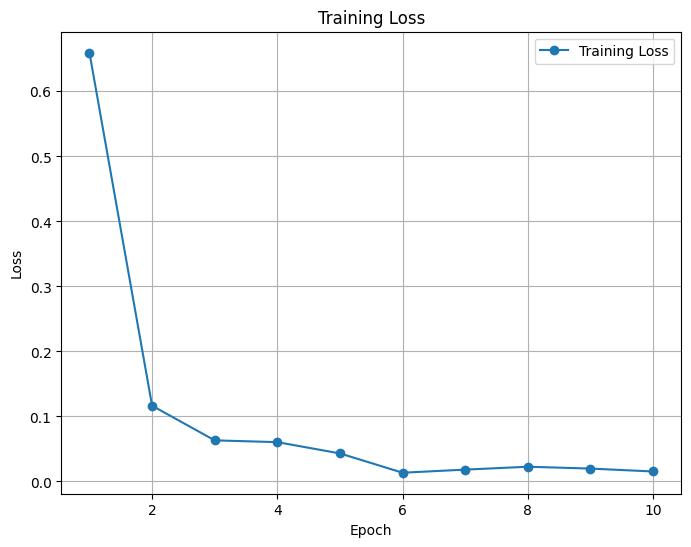

In [ ]:
# Network Train
def train(model, train_loader, num_epochs=10):
    model.train()
    losses = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_function(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total
        losses.append(epoch_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(losses) + 1), losses, marker='o', label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.grid()
    plt.show()

train(resnet, train_loader, num_epochs=10)

Loss: 0.1622, Precision: 96.40%


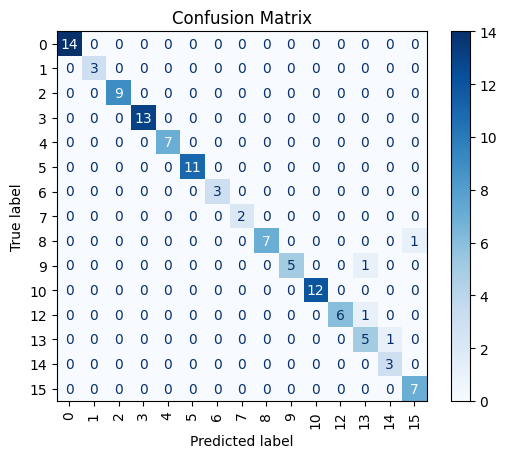

Precision: 0.9560
Recall (Sensitivity): 0.9599
F1-Score: 0.9550


In [ ]:
# Model evaluation and get the confusion matrix
def evaluate_model_with_confusion_matrix(model, test_loader):
    model.eval() 
    test_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad(): 
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            test_loss += loss_function(outputs, labels).item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = 100 * correct / total
    print(f"Loss: {avg_test_loss:.4f}, Precision: {test_accuracy:.2f}%")

    # Create and show the confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    display_labels = sorted(set(all_labels))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
    plt.title("Confusion Matrix")
    plt.show()

    # Calculate evaluation metrics of confusion matrix
    precision = precision_score(all_labels, all_predictions, average='macro')
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')

    print(f"Precision: {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

evaluate_model_with_confusion_matrix(resnet, test_loader)

In [1]:
# Save our own convolutional network model trained
torch.save(model.state_dict(), '4C-4L-10-CEL-Adam-0_001-54_05.pth')
# NConvolutionalLayers-MFullyConnectedLayers-Epochs-LossMethod-Optimizer-Lr-TestAccuracy.pth


NameError: name 'torch' is not defined

In [26]:
# Save the resnet model trained
torch.save(resnet.state_dict(), 'resnet-L4-10-CEL-Adam-0_001-98_2.pth')
# resnet-MFullyConnectedLayers-Epochs-LossMethod-Optimizer-Lr-TestAccuracy.pth